# Lecture 12: Ensembles

UBC 2024-25

<blockquote>
The interests of truth require a diversity of opinions.    
    
by John Stuart Mill
</blockquote>



## Imports

In [4]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.join("code"))

from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *
DATA_DIR = os.path.join("data/")

In [303]:
from utils import *
import matplotlib.pyplot as plt
import mglearn
from imageio import imread
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

def plot_tree_decision_boundary(
    model, X, y, x_label="x-axis", y_label="y-axis", eps=None, ax=None, title=None
):
    if ax is None:
        ax = plt.gca()

    if title is None:
        title = "max_depth=%d" % (model.tree_.max_depth)

    mglearn.plots.plot_2d_separator(
        model, X.to_numpy(), eps=eps, fill=True, alpha=0.5, ax=ax
    )
    mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y, ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)


def plot_tree_decision_boundary_and_tree(
    model, X, y, height=6, width=16, fontsize = 9, x_label="x-axis", y_label="y-axis", eps=None
):
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(width, height),
        subplot_kw={"xticks": (), "yticks": ()},
        gridspec_kw={"width_ratios": [1.5, 2]},
    )
    plot_tree_decision_boundary(model, X, y, x_label, y_label, eps, ax=ax[0])
    custom_plot_tree(model, 
                 feature_names=X.columns.tolist(), 
                 class_names=['A+', 'not A+'],
                 impurity=False,
                 fontsize=fontsize, ax=ax[1])
    ax[1].set_axis_off()
    plt.show()
    
def plot_fruit_tree(ax=None):
    import graphviz

    if ax is None:
        ax = plt.gca()
    mygraph = graphviz.Digraph(
        node_attr={"shape": "box"}, edge_attr={"labeldistance": "10.5"}, format="png"
    )
    mygraph.node("0", "Is tropical?")
    mygraph.node("1", "Has pit?")
    mygraph.node("2", "Is red?")
    mygraph.node("3", "Mango")
    mygraph.node("4", "Banana")
    mygraph.node("5", "Cherry")
    mygraph.node("6", "Kiwi")
    mygraph.edge("0", "1", label="True")
    mygraph.edge("0", "2", label="False")
    mygraph.edge("1", "3", label="True")
    mygraph.edge("1", "4", label="False")
    mygraph.edge("2", "5", label="True")
    mygraph.edge("2", "6", label="False")
    mygraph.render("tmp")
    ax.imshow(imread("tmp.png"))
    ax.set_axis_off()    
    

def plot_knn_clf(X_train, y_train, X_test, n_neighbors=1, class_names=['class 0','class 1'], test_format='star'):
    # credit: This function is based on: https://github.com/amueller/mglearn/blob/master/mglearn/plot_knn_classification.py
    plt.clf()    
    print('n_neighbors', n_neighbors)
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    plot_train_test_points(X_train, y_train, X_test, class_names, test_format)
    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(
                x[0],
                x[1],
                X_train[neighbor, 0] - x[0],
                X_train[neighbor, 1] - x[1],
                head_width=0,
                fc="k",
                ec="k",
            )    
    plt.show()

def plot_knn_decision_boundaries(X_train, y_train, k_values = [1,11,100]):
    fig, axes = plt.subplots(1, len(k_values), figsize=(15, 4))

    for n_neighbors, ax in zip(k_values, axes):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(clf, X_train, y_train, return_train_score=True)
        mean_valid_score = scores["test_score"].mean()
        mean_train_score = scores["train_score"].mean()
        clf.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(
            clf, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.4
        )
        mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
        title = "n_neighbors={}\n train score={}, valid score={}".format(
            n_neighbors, round(mean_train_score, 2), round(mean_valid_score, 2)
        )
        ax.set_title(title)
        ax.set_xlabel("longitude")
        ax.set_ylabel("latitude")
    axes[0].legend(loc=1);    

def plot_train_test_points(X_train, y_train, X_test, class_names=['class 0','class 1'], test_format='star'):
    training_points = mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
    if test_format == "circle": 
        test_points = mglearn.discrete_scatter(
                X_test[:, 0], X_test[:, 1], markers="o", c='k', s=18
            );
    else: 
        test_points = mglearn.discrete_scatter(
                X_test[:, 0], X_test[:, 1], markers="*", c='g', s=16
            );        
    plt.legend(
        training_points + test_points,
        [class_names[0], class_names[1], "test point(s)"],
    )  
    

def plot_support_vectors(svm, X, y):
    mglearn.plots.plot_2d_separator(svm, X, eps=.5)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
    sv = svm.support_vectors_ # plot support vectors
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svm.dual_coef_.ravel() > 0
    mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1");
    


def plot_svc_gamma(param_grid, X_train, y_train, x_label="longitude", y_label='latitude'): 
    fig, axes = plt.subplots(1, len(param_grid), figsize=(len(param_grid)*5, 4))
    for gamma, ax in zip(param_grid, axes):
        clf = SVC(gamma=gamma)
        scores = cross_validate(clf, X_train, y_train, return_train_score=True)
        mean_valid_score = scores["test_score"].mean()
        mean_train_score = scores["train_score"].mean()
        clf.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(
            clf, X_train, fill=True, eps=0.5, ax=ax, alpha=0.4
        )
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        title = "gamma={}\n train score={}, valid score={}".format(
            gamma, round(mean_train_score, 2), round(mean_valid_score, 2)
        )
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    axes[0].legend(loc=1);    
    
def plot_svc_C(param_grid, X_train, y_train, x_label="longitude", y_label='latitude'): 
    fig, axes = plt.subplots(1, len(param_grid), figsize=(len(param_grid)*5, 4))
    for C, ax in zip(param_grid, axes):
        clf = SVC(C=C, gamma=0.01)
        scores = cross_validate(clf, X_train, y_train, return_train_score=True)
        mean_valid_score = scores["test_score"].mean()
        mean_train_score = scores["train_score"].mean()
        clf.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(
            clf, X_train, fill=True, eps=0.5, ax=ax, alpha=0.4
        )
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        title = "C={}\n train score={}, valid score={}".format(
            C, round(mean_train_score, 2), round(mean_valid_score, 2)
        )
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    axes[0].legend(loc=1);    
    



def make_bracket(s, xy, textxy, width, ax):
    annotation = ax.annotate(
        s, xy, textxy, ha="center", va="center", size=20,
        arrowprops=dict(arrowstyle="-[", fc="w", ec="k",
                        lw=2,), bbox=dict(boxstyle="square", fc="w"))
    annotation.arrow_patch.get_arrowstyle().widthB = width

    
def plot_improper_processing(estimator_name):
    # Adapted from https://github.com/amueller/mglearn/blob/106cf48ef03710ef1402813997746741aa6467da/mglearn/plot_improper_preprocessing.py#L12
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    for axis in axes:
        bars = axis.barh([0, 0, 0], [11.9, 2.9, 4.9], left=[0, 12, 15],
                         color=['white', 'grey', 'grey'], hatch="//",
                         align='edge', edgecolor='k')
        bars[2].set_hatch(r"")
        axis.set_yticks(())
        axis.set_frame_on(False)
        axis.set_ylim(-.1, 6)
        axis.set_xlim(-0.1, 20.1)
        axis.set_xticks(())
        axis.tick_params(length=0, labeltop=True, labelbottom=False)
        axis.text(6, -.3, "training folds",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(13.5, -.3, "validation fold",
                  fontdict={'fontsize': 14}, horizontalalignment="center")
        axis.text(17.5, -.3, "test set",
                  fontdict={'fontsize': 14}, horizontalalignment="center")

    make_bracket("scaler fit", (7.5, 1.3), (7.5, 2.), 15, axes[0])
    make_bracket(estimator_name + " fit", (6, 3), (6, 4), 12, axes[0])
    make_bracket(estimator_name + "predict", (13.4, 3), (13.4, 4), 2.5, axes[0])

    axes[0].set_title("Cross validation")
    axes[1].set_title("Test set prediction")

    make_bracket("scaler fit", (7.5, 1.3), (7.5, 2.), 15, axes[1])
    make_bracket(estimator_name + " fit", (7.5, 3), (7.5, 4), 15, axes[1])
    make_bracket(estimator_name + " predict", (17.5, 3), (17.5, 4), 4.8, axes[1])    
    
    
def plot_proper_processing(estimator_name):
    # Adapted from https://github.com/amueller/mglearn/blob/106cf48ef03710ef1402813997746741aa6467da/mglearn/plot_improper_preprocessing.py#L12
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    for axis in axes:
        bars = axis.barh([0, 0, 0], [11.9, 2.9, 4.9],
                         left=[0, 12, 15], color=['white', 'grey', 'grey'],
                         hatch="//", align='edge', edgecolor='k')
        bars[2].set_hatch(r"")
        axis.set_yticks(())
        axis.set_frame_on(False)
        axis.set_ylim(-.1, 4.5)
        axis.set_xlim(-0.1, 20.1)
        axis.set_xticks(())
        axis.tick_params(length=0, labeltop=True, labelbottom=False)
        axis.text(6, -.3, "training folds", fontdict={'fontsize': 14},
                  horizontalalignment="center")
        axis.text(13.5, -.3, "validation fold", fontdict={'fontsize': 14},
                  horizontalalignment="center")
        axis.text(17.5, -.3, "test set", fontdict={'fontsize': 14},
                  horizontalalignment="center")

    make_bracket("scaler fit", (6, 1.3), (6, 2.), 12, axes[0])
    make_bracket(estimator_name + " fit", (6, 3), (6, 4), 12, axes[0])
    make_bracket(estimator_name + " predict", (13.4, 3), (13.4, 4), 2.5, axes[0])

    axes[0].set_title("Cross validation")
    axes[1].set_title("Test set prediction")

    make_bracket("scaler fit", (7.5, 1.3), (7.5, 2.), 15, axes[1])
    make_bracket(estimator_name + " fit", (7.5, 3), (7.5, 4), 15, axes[1])
    make_bracket(estimator_name + " predict", (17.5, 3), (17.5, 4), 4.8, axes[1])
    fig.subplots_adjust(hspace=.3)
    
def plot_original_scaled(
    X_train,
    X_test,
    train_transformed,
    test_transformed,
    title_transformed="Properly transformed",
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], label="Training set", s=60)
    axes[0].scatter(
        X_test[:, 0],
        X_test[:, 1],
        marker="^",
        color=mglearn.cm2(1),
        label="Test set",
        s=60,
    )
    axes[0].legend(loc="upper right")

    axes[0].set_title("Original Data")

    axes[1].scatter(
        train_transformed[:, 0], train_transformed[:, 1], label="Training set", s=60
    )
    axes[1].scatter(
        test_transformed[:, 0],
        test_transformed[:, 1],
        marker="^",
        color=mglearn.cm2(1),
        label="Test set",
        s=60,
    )
    axes[1].legend(loc="upper right")
    axes[1].set_title(title_transformed);    
    
    
def plot_logistic_regression(x, w):
    import graphviz
    sentiment = 'pos' if sum(w) > 0 else 'neg'    
    lr_graph = graphviz.Digraph(node_attr={'shape': 'circle', 'fixedsize': 'False'},
                                graph_attr={'rankdir': 'LR', 'splines': 'line'})
    inputs = graphviz.Digraph(node_attr={'shape': 'circle'}, name="cluster_0")
    output = graphviz.Digraph(node_attr={'shape': 'circle'}, name="cluster_2")

    for i in range(len(x)):
        inputs.node(x[i], labelloc="c")
    inputs.body.append('label = "inputs"')
    inputs.body.append('color = "white"')

    lr_graph.subgraph(inputs)

    output.body.append('label = "output"')
    output.body.append('color = "white"')
    output.node("y_hat=%s" %sentiment)

    lr_graph.subgraph(output)
    print('Weighted sum of the input features = %0.3f y_hat = %s' %(sum(w), sentiment))
    for i in range(len(w)):
        lr_graph.edge(x[i], "y_hat=%s" %sentiment, label=str(w[i]))
    return lr_graph    
    
def plot_confusion_matrix_ex(tn, fp, fn, tp, target='Fraud'):
    plt.figure(figsize=(7, 7))
    confusion = np.array([[tn, fp], [fn, tp]])
    plt.text(0.40, .7, confusion[0, 0], size=45, horizontalalignment='right')
    plt.text(0.40, .2, confusion[1, 0], size=45, horizontalalignment='right')
    plt.text(.90, .7, confusion[0, 1], size=45, horizontalalignment='right')
    plt.text(.90, 0.2, confusion[1, 1], size=45, horizontalalignment='right')
    plt.xticks([.25, .75], ["predicted not " + target, "predicted " + target], size=20, rotation=25)
    plt.yticks([.25, .75], ["true " + target, "true not " + target ], size=20)
    plt.plot([.5, .5], [0, 1], '--', c='k')
    plt.plot([0, 1], [.5, .5], '--', c='k')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    

def plot_confusion_matrix_example(tn, fp, fn, tp, target='Fraud'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'xticks': (), 'yticks': ()})

    plt.setp(ax, xticks=[.25, .75], xticklabels=["predicted not " + target, "predicted " + target],
       yticks=[.25, .75], yticklabels=["true " + target, "true not " + target ])    
    confusion = np.array([[tn, fp], [fn, tp]])
    ax[0].text(0.40, .7, confusion[0, 0], size=45, horizontalalignment='right')
    ax[0].text(0.40, .2, confusion[1, 0], size=45, horizontalalignment='right')
    ax[0].text(.90, .7, confusion[0, 1], size=45, horizontalalignment='right')
    ax[0].text(.90, 0.2, confusion[1, 1], size=45, horizontalalignment='right')
    ax[0].plot([.5, .5], [0, 1], '--', c='k')
    ax[0].plot([0, 1], [.5, .5], '--', c='k')

    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)    
    
    ax[1].text(0.45, .6, "TN", size=100, horizontalalignment='right')
    ax[1].text(0.45, .1, "FN", size=100, horizontalalignment='right')
    ax[1].text(.95, .6, "FP", size=100, horizontalalignment='right')
    ax[1].text(.95, 0.1, "TP", size=100, horizontalalignment='right')
    ax[1].plot([.5, .5], [0, 1], '--', c='k')
    ax[1].plot([0, 1], [.5, .5], '--', c='k')
    ax[1].yaxis.set_tick_params(labelsize=12)
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, 1)  
    
def make_num_tree_plot(preprocessor, X_train, y_train, X_test, y_test, num_trees, scoring_metric='accuracy'):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for ntree in num_trees:
        model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=ntree))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(num_trees, train_scores, label="train")
    plt.semilogx(num_trees, test_scores, label="cv")
    plt.legend()
    plt.xlabel("number of trees")
    plt.ylabel("scores") 

#[Code credit](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#linear-models)
def plot_multiclass_lr_ovr(lr, X_train, y_train, n_classes, test_points=None, decision_boundary=False):    
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
    line = np.linspace(-15, 15)
    colors = ['b','g','r','c', 'm','y', 'bisque', 'olivedrab']
    for coef, intercept, color in zip(lr.coef_, lr.intercept_, colors[:n_classes]):
        plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
    plt.ylim(-10, 15)
    plt.xlim(-10, 8)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    legend_labels = []
    for cl in range(n_classes):
        legend_labels.append("Class " + str(cl))
    for cl in range(n_classes):
        legend_labels.append("Line class " + str(cl))
    plt.legend(
        legend_labels,
        loc=(1.01, 0.3),
    );
    if test_points:
        for test_point in test_points: 
            plt.plot(test_point[0], test_point[1], "k*", markersize=16)
    if decision_boundary:
        mglearn.plots.plot_2d_classification(lr, X_train, fill=True, alpha=0.7)
        

In [305]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree

import glob

# visualization
import graphviz
import matplotlib.pyplot as plt
from imageio import imread

plt.rcParams["font.size"] = 16

# Custom function to customize the tree plot and hide values and samples
def custom_plot_tree(tree_model, feature_names=None, class_names=None, **kwargs):
    """
    Customizes and displays a tree plot for a scikit-learn Decision Tree Classifier.

    Parameters:
    - tree (sklearn.tree.DecisionTreeClassifier): The trained Decision Tree Classifier to visualize.
    - width: width of the matplotlib plot in inches 
    - height: height of the matplotlib plot in inches 
    - feature_names (list or None): A list of feature names to label the tree nodes with feature names.
                                    If None, generic feature names will be used.
    - class_names (list or None): A list of class names to label the tree nodes with class names.
                                  If None, generic class names will be used.
    - **kwargs: Additional keyword arguments to be passed to the `sklearn.tree.plot_tree` function.

    Returns:
    - None: The function displays the customized tree plot using Matplotlib.
    
    This function customizes the appearance of a Decision Tree plot generated by the scikit-learn
    `plot_tree` function. It hides both the samples and values in each node of the tree plot
    for improved visualization.
    """    
    plot_tree(tree_model, 
              feature_names=feature_names, 
              class_names=class_names, 
              filled=True, 
              **kwargs)
    
    # Customize the appearance of the text elements for each node
    for text in plt.gca().texts:
        new_text = re.sub(r'samples = \d+\n', '', text.get_text()) # Hide samples
        text.set_text(new_text) 
    
    plt.show()

def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()

    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [296]:
import plotting_functions

In [298]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br><br><br>

## Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [182]:
adult_df_large = pd.read_csv(DATA_DIR + "adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [184]:
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]

ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "race", "education.num"]
target_column = "income"

In [186]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [188]:
assert set(education_levels) == set(train_df["education"].unique())

In [190]:
numeric_transformer = StandardScaler()

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [192]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'capital.gain', 'capital.loss',
                                  'hours.per.week']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate']],
                                                dtype=<class...
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>))]),
                                 ['sex']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'native.country']),
                                ('drop', 'drop',
                                 ['fnlwgt', 'race', 'education.num'])])

In [194]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [197]:
train_df["income"].value_counts(normalize=True)

income
<=50K    0.757985
>50K     0.242015
Name: proportion, dtype: float64

In [199]:
scoring_metric = "accuracy"

We are going to use models outside sklearn. Some of them cannot handle categorical target values. So we'll convert them to integers using `LabelEncoder`. 

In [202]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

In [204]:
y_train_num

array([0, 0, 0, ..., 1, 1, 0], shape=(26048,))

Let's store all the results in a dictionary called `results`. 

In [207]:
results = {}

### Baselines

####  `DummyClassifier` baseline

In [211]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

#### `DecisionTreeClassifier` baseline

- Let's try decision tree classifier on our data. 

In [215]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.005 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.196 (+/- 0.021),0.015 (+/- 0.001),0.817 (+/- 0.006),0.979 (+/- 0.000)


Decision tree is clearly overfitting. 

<br><br><br><br>

## Random forests 

![](img/eva-forest.jpg)

### General idea

- A single decision tree is likely to overfit
- Use a collection of diverse decision trees
- Each tree overfits on some part of the data but we can reduce overfitting by averaging the results 
    - can be shown mathematically

### `RandomForestClassifier` 

- Before understanding the details let's first try it out.  

In [222]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=123,
    ),
)
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.011 (+/- 0.001),0.005 (+/- 0.001),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.196 (+/- 0.021),0.015 (+/- 0.001),0.817 (+/- 0.006),0.979 (+/- 0.000)
Random forests,0.639 (+/- 0.037),0.056 (+/- 0.009),0.847 (+/- 0.006),0.979 (+/- 0.000)


The validation scores are better although it seems likes we are still overfitting. 

### How do they work? 

- Decide how many decision trees we want to build
    - can control with `n_estimators` hyperparameter 
- `fit` a diverse set of that many decision trees by **injecting randomness** in the model construction
- `predict` by voting (classification) or averaging (regression) of predictions given by individual models

### Inject randomness in the classifier construction

To ensure that the trees in the random forest are different we inject randomness in two ways:  

1. Data: **Build each tree on a bootstrap sample** (i.e., a sample drawn **with replacement** from the training set)
2. Features: **At each node, select a random subset of features** (controlled by `max_features` in `scikit-learn`) and look for the best possible test involving one of these features   

### An example of a bootstrap samples

- Suppose you are training a random forest model with `n_estimators=3`. 
- Suppose this is your original dataset with six examples: [0,1,2,3,4,5]
    - a sample drawn with replacement for tree 1: [1,1,3,3,3,4]
    - a sample drawn with replacement for tree 2: [3,2,2,2,1,1]
    - a sample drawn with replacement for tree 3: [0,0,0,4,4,5]
- Each decision tree trains on a total of six examples.
- Each tree trains on a different set of examples. 

In [227]:
random_forest_data = {'original':[1, 1, 1, 1, 1, 1], 'tree1':[0, 2, 0, 3, 1, 0], 'tree2':[0, 2, 3, 1, 0, 0], 'tree3':[3, 0, 0, 0, 2, 1]}
pd.DataFrame(random_forest_data)

,original,tree1,tree2,tree3
0,1,0,0,3
1,1,2,2,0
2,1,0,3,0
3,1,3,1,0
4,1,1,0,2
5,1,0,0,1


### The random forests classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node).
    - Find the best split on the selected features. 
    - Grow the trees to maximum depth.
    
- Prediction time    
    - Vote the trees to get predictions for new example. 

### Example 

- Let's create a random forest with 3 estimators. 
- I'm using `max_depth=2` for easy visualization. 

In [232]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train_num);

- Let's get the feature names of transformed features.

In [235]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + pipe_rf_demo.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names[:10]

['age',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private']

We can also get them directly, as shown below. 

In [238]:
feature_names = pipe_rf_demo.named_steps['columntransformer'].get_feature_names_out()
feature_names

array(['standardscaler__age', 'standardscaler__capital.gain',
       'standardscaler__capital.loss', 'standardscaler__hours.per.week',
       'ordinalencoder__education', 'pipeline-1__sex_Male',
       'pipeline-2__workclass_Federal-gov',
       'pipeline-2__workclass_Local-gov',
       'pipeline-2__workclass_Never-worked',
       'pipeline-2__workclass_Private',
       'pipeline-2__workclass_Self-emp-inc',
       'pipeline-2__workclass_Self-emp-not-inc',
       'pipeline-2__workclass_State-gov',
       'pipeline-2__workclass_Without-pay',
       'pipeline-2__workclass_missing',
       'pipeline-2__marital.status_Divorced',
       'pipeline-2__marital.status_Married-AF-spouse',
       'pipeline-2__marital.status_Married-civ-spouse',
       'pipeline-2__marital.status_Married-spouse-absent',
       'pipeline-2__marital.status_Never-married',
       'pipeline-2__marital.status_Separated',
       'pipeline-2__marital.status_Widowed',
       'pipeline-2__occupation_Adm-clerical',
       'p

- Let's sample a test example where income > 50k. 

In [241]:
probs = pipe_rf_demo.predict_proba(X_test)
np.where(probs[:, 1] > 0.55)

(array([ 582, 1271, 1991, 2268, 2447, 2516, 2556, 4151, 4165, 5294, 5798,
        5970, 6480]),)

In [243]:
test_example = X_test.iloc[[582]]
pipe_rf_demo.predict_proba(test_example)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))
transformed_example = preprocessor.transform(test_example)
pd.DataFrame(data=transformed_example.flatten(), index=feature_names)

Classes:  [0 1]
Prediction by random forest:  [1]


,0
standardscaler__age,0.550004
standardscaler__capital.gain,-0.147166
standardscaler__capital.loss,-0.217680
standardscaler__hours.per.week,1.579660
ordinalencoder__education,15.000000
...,...
pipeline-2__native.country_Trinadad&Tobago,0.000000
pipeline-2__native.country_United-States,1.000000
pipeline-2__native.country_Vietnam,0.000000
pipeline-2__native.country_Yugoslavia,0.000000


- We can look at different trees created by random forest. 
- Note that each tree looks at different set of features and slightly different data. 

In [309]:
sys.path.append("/home/giuliosp/Desktop/CPSC 330/Practice/demo_11/code")
import plotting_functions
import utils



Tree 1


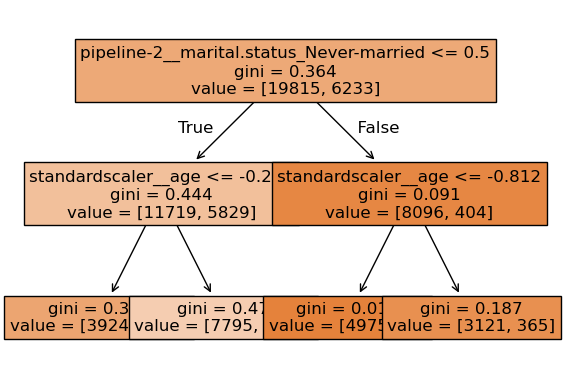

None

prediction [0.]


Tree 2


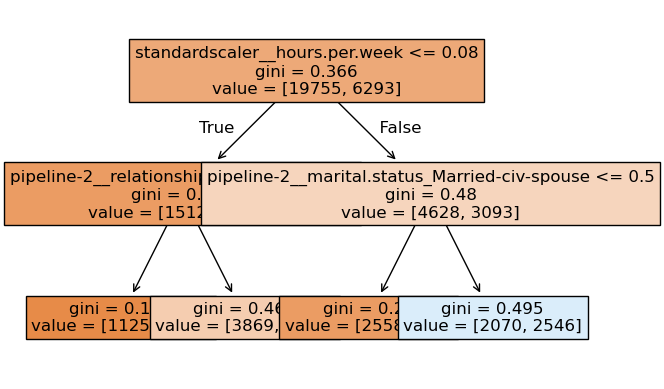

None

prediction [1.]


Tree 3


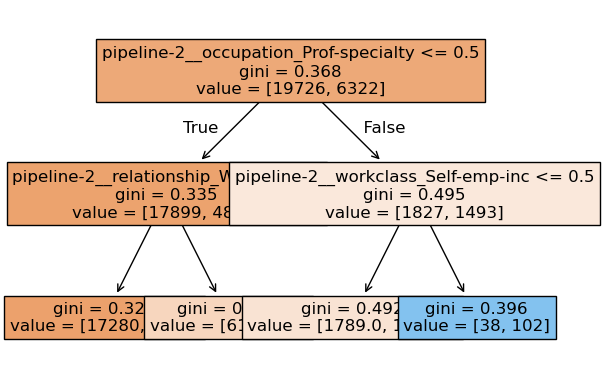

None

prediction [1.]


In [311]:
for i, tree in enumerate(
    pipe_rf_demo.named_steps["randomforestclassifier"].estimators_
):
    print("\n\nTree", i + 1)
    display(custom_plot_tree(tree, feature_names, fontsize=12))
    print("prediction", tree.predict(preprocessor.transform(test_example)))

### Some important hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)


### Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 

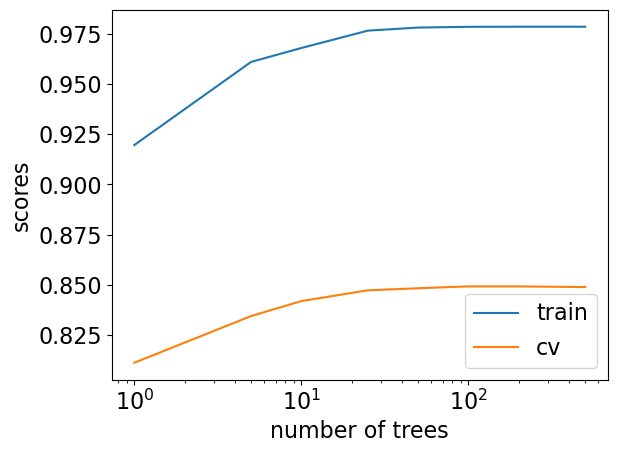

In [315]:
make_num_tree_plot(
    preprocessor, X_train, y_train, X_test, y_test, [1, 5, 10, 25, 50, 100, 200, 500]
) # User-defined function defined in code/plotting_functions.py 

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by increasing training score and not decreasing validation score much.
- You'll often see a high training scores for in the context of random forests. That's normal. It doesn't mean that the model is overfitting. 
- While ensembles often offer improved performance, this benefit isn't always guaranteed.
- Always opting for more trees in a random forest is preferable, but we sometimes choose fewer trees for faster performance.


### Strengths and weaknesses

- Usually one of the best performing off-the-shelf classifiers without heavy tuning of hyperparameters
- Don't require scaling of data 
- Less likely to overfit 
- Slower than decision trees because we are fitting multiple trees but can easily parallelize training because all trees are independent of each other 
- In general, able to capture a much broader picture of the data compared to a single decision tree. 

### Weaknesses

- Require more memory 
- Hard to interpret
- Tend not to perform well on high dimensional sparse data such as text data


```{seealso}
There is also something called [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) where randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. 
[Source](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)
```

```{important}
Make sure to set the `random_state` for reproducibility. Changing the `random_state` can have a big impact on the model and the results due to the random nature of these models. Having more trees can get you a more robust estimate. 
```

```{seealso}
[The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman. 
```

## ❓❓ Questions for you

### iClicker Exercise 12.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select the most accurate option below.**

- (A) Every tree in a random forest uses a different bootstrap sample of the training set.
- (B) To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features.
- (C) The `n_estimators` hyperparameter of random forests should be tuned to get a better performance on the validation or test data.  
- (D) In random forests we build trees in a sequential fashion, where the current tree is dependent upon the previous tree.  
- (E) Let classifiers A, B, and C have training errors of 10%, 20%, and 30%, respectively. Then, the best possible training error from averaging A, B and C is 10%.

- Why do we create random forests out of random trees (trees where each stump only looks at a subset of the features, and the dataset is a bootstrap sample) rather than creating them out of regular decision trees?

<br><br><br><br>

## Gradient boosted trees [[video](https://youtu.be/EkFkY9QB2Hw)]

Another popular and effective class of tree-based models is gradient boosted trees. 

- No randomization.
- The key idea is combining many simple models called weak learners to create a strong learner. 
- They combine multiple shallow (depth 1 to 5) decision trees.  
- They build trees in a serial manner, where each tree tries to correct the mistakes of the previous one. 

### (Optional) Prediction in boosted regression trees

- Credit: Adapted from [CPSC 340 notes](https://www.students.cs.ubc.ca/~cs-340/L24.pdf)
- Gradient boosting starts with an ensemble of $k$ shallow decision trees. 
- For each example $i$, each shallow tree makes a continuous prediction: $\hat{y}_{i1}, \hat{y}_{i2}, \dots, \hat{y}_{ik}$
- The final prediction is sum of individual predictions: $\hat{y}_{i1} + \hat{y}_{i2} + \dots + \hat{y}_{ik}$
- Note that we do not use the average as we would with random forests because  
    - In boosting, each tree is not individually trying to predict the true $y_i$ value
    - Instead, each new tree tries to "fix" the prediction made by the old trees, so that sum is $y_i$

### (Optional) Fitting in boosted regression trees. 
Consider the following "gradient tree boosting" procedure:

```
Tree[1].fit(X,y)
y_hat = Tree[1].predict(X)
Tree[2].fit(X,y - y_hat)
y_hat = y_hat + Tree[2].predict(X)
Tree[3].fit(X,y - y_hat)
y_hat = y_hat + Tree[3].predict(X)
Tree[4].fit(X,y - y_hat)
y_hat = y_hat + Tree[4].predict(X)
```

- Each tree is trying to predict residuals (`y - y_hat`) of current prediction.
    - True label is 0.9, old prediction is 0.8, so I can improve `y_hat` by predicting 0.1.

<br><br>

We'll not go into the details. If you want to know more, here are some resources: 
- [UBC CPSC 340 Gradient Boosting notes](https://www.students.cs.ubc.ca/~cs-340/L24.pdf)
- [Gradient Boosted Decision Trees by Google Developer](https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt)

We'll look at brief examples of using the following three gradient boosted tree models. 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) 
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)

### [XGBoost](https://xgboost.ai/about) 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge xgboost`
- Supports missing values
- GPU training, networked parallel training
- Supports sparse data
- Typically better scores than random forests    

### [LightGBM](https://lightgbm.readthedocs.io/)

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge lightgbm`
- Small model size
- Faster 
- Typically better scores than random forests    

Main hyperparameters

### [CatBoost](https://catboost.ai/)

- Not part of `sklearn` but has similar interface. 
- Install it in your course conda environment: `conda install -c conda-forge catboost`
- Usually better scores but slower compared to `XGBoost` and `LightGBM`     

### Important hyperparameters

- `n_estimators` $\rightarrow$ Number of boosting rounds
- `learning_rate` $\rightarrow$ The learning rate of training
    - controls how strongly each tree tries to correct the mistakes of the previous trees
    - higher learning rate means each tree can make stronger corrections, which means more complex model 
- `max_depth` $\rightarrow$ `max_depth` of trees (similar to decision trees) 
- `scale_pos_weight` $\rightarrow$ Balancing of positive and negative weights

In our demo below, we'll just give equal weight to both classes because we are trying to optimize accuracy. But if you want to give more weight to class 1, for example, you can calculate the data imbalance ratio and set `scale_pos_weight` hyperparameter with that weight. 

In [324]:
ratio = np.bincount(y_train_num)[0] / np.bincount(y_train_num)[1]
ratio

np.float64(3.1319796954314723)

### Gradient boosting in `sklearn`

sklearn also has gradient boosting models. 

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) and [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor)  (Inspired by LGBM, supports missing values)

Let's try out all these models. 

In [328]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        random_state=123, verbosity=0
    ),
)
pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123, verbose=-1)
)

pipe_catboost = make_pipeline(
    preprocessor,
    CatBoostClassifier(verbose=0, random_state=123),
)

pipe_sklearn_histGB = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier(random_state=123),
)

pipe_sklearn_GB = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(random_state=123),
)

classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [330]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [332]:
results = {}

In [334]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [335]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)

In [337]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.014 (+/- 0.005),0.006 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.760 (+/- 0.136),0.024 (+/- 0.005),0.849 (+/- 0.005),0.850 (+/- 0.001)
decision tree,0.191 (+/- 0.023),0.015 (+/- 0.002),0.817 (+/- 0.006),0.979 (+/- 0.000)
random forest,2.026 (+/- 0.090),0.102 (+/- 0.007),0.844 (+/- 0.007),0.976 (+/- 0.001)
XGBoost,0.285 (+/- 0.063),0.027 (+/- 0.003),0.872 (+/- 0.004),0.897 (+/- 0.001)
LightGBM,0.203 (+/- 0.062),0.028 (+/- 0.002),0.872 (+/- 0.004),0.888 (+/- 0.000)
CatBoost,5.019 (+/- 0.319),0.173 (+/- 0.008),0.872 (+/- 0.003),0.895 (+/- 0.001)
sklearn_histGB,0.734 (+/- 0.058),0.035 (+/- 0.006),0.871 (+/- 0.005),0.887 (+/- 0.002)
sklearn_GB,3.390 (+/- 0.178),0.021 (+/- 0.001),0.864 (+/- 0.004),0.870 (+/- 0.001)


**Some observations**
- Keep in mind all these results are with default hyperparameters
- Ideally we would carry out hyperparameter optimization for all of them and then compare the results. 
- We are using a particular scoring metric (accuracy in this case)
- We are scaling numeric features but it shouldn't matter for tree-based models
- Look at the standard deviation. Doesn't look very high. 
    - The scores look more or less stable. 

In [359]:
rst=pd.DataFrame(results).T
rst.sort_values(by='test_score')

,fit_time,score_time,test_score,train_score
Dummy,0.014 (+/- 0.005),0.006 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.191 (+/- 0.023),0.015 (+/- 0.002),0.817 (+/- 0.006),0.979 (+/- 0.000)
random forest,2.026 (+/- 0.090),0.102 (+/- 0.007),0.844 (+/- 0.007),0.976 (+/- 0.001)
logistic regression,0.760 (+/- 0.136),0.024 (+/- 0.005),0.849 (+/- 0.005),0.850 (+/- 0.001)
sklearn_GB,3.390 (+/- 0.178),0.021 (+/- 0.001),0.864 (+/- 0.004),0.870 (+/- 0.001)
sklearn_histGB,0.734 (+/- 0.058),0.035 (+/- 0.006),0.871 (+/- 0.005),0.887 (+/- 0.002)
CatBoost,5.019 (+/- 0.319),0.173 (+/- 0.008),0.872 (+/- 0.003),0.895 (+/- 0.001)
XGBoost,0.285 (+/- 0.063),0.027 (+/- 0.003),0.872 (+/- 0.004),0.897 (+/- 0.001)
LightGBM,0.203 (+/- 0.062),0.028 (+/- 0.002),0.872 (+/- 0.004),0.888 (+/- 0.000)


- Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest. 
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost.
    - Among the best performing models, LightGBM is the fastest one!
- Scores times  
    - Prediction times are much smaller in all cases. 

<br><br>

### Which model should I use?

**Simple answer**
- Whichever gets the highest CV score making sure that you're not overusing the validation set.

**Interpretability**
- This is an area of growing interest and concern in ML.
- How important is interpretability for you? 
- In the next class we'll talk about interpretability of non-linear models. 


**Speed/code maintenance**
- Other considerations could be speed (fit and/or predict), maintainability of the code.

Finally, you could use all of them!

<br><br><br><br>

## Averaging 

Earlier we looked at a bunch of classifiers:

In [369]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'XGBoost', 'LightGBM', 'CatBoost', 'sklearn_histGB', 'sklearn_GB'])

For this demonstration, let's get rid of sklearn's gradient boosting models and CatBoost because it's too slow. 

In [372]:
del classifiers["sklearn_histGB"]
del classifiers["sklearn_GB"]
del classifiers["CatBoost"]

In [374]:
classifiers.keys()

dict_keys(['logistic regression', 'decision tree', 'random forest', 'XGBoost', 'LightGBM'])

What if we use all the models in `classifiers` and let them vote during prediction time? 

In [377]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross-validation to work!

In [379]:
from sklearn import set_config

set_config(display="diagram")  # global setting

In [381]:
averaging_model

VotingClassifier(estimators=[('logistic regression',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'capital.gain',
                                                                                 'capital.loss',
                                                                                 'hours.per.week']),
                                                                               ('ordinalencoder',
                                                                                OrdinalEncoder(categories=[['Preschool',
                                                                                                            '1st-4th',
                                                                                                            '5th-6th',
                                                                                                            '7th-8th',
                                                                                                            '9th',
                                                                                                            '10th',
                                                                                                            '11th',
                                                                                                            '12th',
                                                                                                            'HS-grad',
                                                                                                            'Prof-school',...
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(fill_value='missing',
                                                                                                               strategy='constant')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                ['workclass',
                                                                                 'marital.status',
                                                                                 'occupation',
                                                                                 'relationship',
                                                                                 'native.country']),
                                                                               ('drop',
                                                                                'drop',
                                                                                ['fnlwgt',
                                                                                 'race',
                                                                                 'education.num'])])),
                                              ('lgbmclassifier',
                                               LGBMClassifier(random_state=123,
                                                              verbose=-1))]))],
                 voting='soft')

This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifier pipelines.

Main parameter: `voting`
- `voting='hard'` 
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.

- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [386]:
averaging_model.fit(X_train, y_train_num);

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models.    

```{note}
It seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.
```

Let's look at particular test examples where `income` is ">50k" (y=1):

In [390]:
test_g50k = (
    test_df.query("income == '>50K'")
    .sample(4, random_state=42)
    .drop(columns=["income"])
)
test_l50k = (
    test_df.query("income == '<=50K'")
    .sample(4, random_state=2)
    .drop(columns=["income"])
)

In [391]:
averaging_model.classes_

array([0, 1])

What are the predictions given by the voting model? 

In [393]:
data = {"y": 1, "Voting classifier": averaging_model.predict(test_g50k)}
pd.DataFrame(data)

,y,Voting classifier
0,1,1
1,1,1
2,1,1
3,1,1


For hard voting, these are the votes:

In [395]:
r1 = {
    name: classifier.predict(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
data.update(r1)
pd.DataFrame(data)

,y,Voting classifier,logistic regression,decision tree,random forest,XGBoost,LightGBM
0,1,1,1,1,1,1,1
1,1,1,0,1,1,1,0
2,1,1,1,0,1,1,1
3,1,1,1,0,1,1,1


For soft voting, these are the scores:

In [402]:
r2 = {
    name: classifier.predict_proba(test_g50k)[:, 1]
    for name, classifier in averaging_model.named_estimators_.items()
}

data.update(r2)
pd.DataFrame(data)

,y,Voting classifier,logistic regression,decision tree,random forest,XGBoost,LightGBM
0,1,1,0.661784,1.0,0.760000,0.669376,0.685786
1,1,1,0.248213,1.0,0.678924,0.581217,0.463582
2,1,1,0.635709,0.5,0.621537,0.684623,0.665882
3,1,1,0.614872,0.0,0.770000,0.679356,0.683015


(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

What's the prediction probability of the averaging model? Let's examine prediction probability of the first example from `test_g50k`. 

In [406]:
averaging_model.predict_proba(test_g50k)[1]

array([0.40561284, 0.59438716])

It adds the prediction probabilities given by constituent models and divides the summation by the number of constituent models. 

In [409]:
# Sum of probabilities for class 0 at index 1
sum_prob_ex1_class_0 = np.sum(
    [
        classifier.predict_proba(test_g50k)[1][0]
        for name, classifier in averaging_model.named_estimators_.items()
    ]
)
sum_prob_ex1_class_0

np.float64(2.0280642215398803)

In [411]:
# Sum of probabilities for class 1 at index 1
sum_prob_ex1_class_1 = np.sum(
    [
        classifier.predict_proba(test_g50k)[1][1]
        for name, classifier in averaging_model.named_estimators_.items()
    ]
)
sum_prob_ex1_class_1

np.float64(2.9719357784601197)

In [413]:
n_constituents = len(averaging_model.named_estimators_)
n_constituents

5

In [415]:
sum_prob_ex1_class_0 / n_constituents, sum_prob_ex1_class_1 / n_constituents

(np.float64(0.40561284430797606), np.float64(0.5943871556920239))

In [417]:
averaging_model.predict_proba(test_g50k)[1]

array([0.40561284, 0.59438716])

They match! 

Let's see how well this model performs.

In [421]:
averaging_model.predict_proba(test_g50k)[2]

array([0.3784499, 0.6215501])

In [423]:
results["Voting"] = mean_std_cross_val_scores(
    averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [424]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.014 (+/- 0.005),0.006 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.760 (+/- 0.136),0.024 (+/- 0.005),0.849 (+/- 0.005),0.850 (+/- 0.001)
decision tree,0.191 (+/- 0.023),0.015 (+/- 0.002),0.817 (+/- 0.006),0.979 (+/- 0.000)
random forest,2.026 (+/- 0.090),0.102 (+/- 0.007),0.844 (+/- 0.007),0.976 (+/- 0.001)
XGBoost,0.285 (+/- 0.063),0.027 (+/- 0.003),0.872 (+/- 0.004),0.897 (+/- 0.001)
LightGBM,0.203 (+/- 0.062),0.028 (+/- 0.002),0.872 (+/- 0.004),0.888 (+/- 0.000)
CatBoost,5.019 (+/- 0.319),0.173 (+/- 0.008),0.872 (+/- 0.003),0.895 (+/- 0.001)
sklearn_histGB,0.734 (+/- 0.058),0.035 (+/- 0.006),0.871 (+/- 0.005),0.887 (+/- 0.002)
sklearn_GB,3.390 (+/- 0.178),0.021 (+/- 0.001),0.864 (+/- 0.004),0.870 (+/- 0.001)
Voting,3.358 (+/- 0.368),0.205 (+/- 0.021),0.859 (+/- 0.005),0.953 (+/- 0.000)


It appears that here we didn't do much better than our best classifier :(. 

Let's try removing decision tree classifier. 

In [467]:
classifiers_ndt = classifiers.copy()
del classifiers_ndt["decision tree"]
averaging_model_ndt = VotingClassifier(
    list(classifiers_ndt.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_ndt"] = mean_std_cross_val_scores(
    averaging_model_ndt,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)

/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [433]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.014 (+/- 0.005),0.006 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.760 (+/- 0.136),0.024 (+/- 0.005),0.849 (+/- 0.005),0.850 (+/- 0.001)
decision tree,0.191 (+/- 0.023),0.015 (+/- 0.002),0.817 (+/- 0.006),0.979 (+/- 0.000)
random forest,2.026 (+/- 0.090),0.102 (+/- 0.007),0.844 (+/- 0.007),0.976 (+/- 0.001)
XGBoost,0.285 (+/- 0.063),0.027 (+/- 0.003),0.872 (+/- 0.004),0.897 (+/- 0.001)
LightGBM,0.203 (+/- 0.062),0.028 (+/- 0.002),0.872 (+/- 0.004),0.888 (+/- 0.000)
CatBoost,5.019 (+/- 0.319),0.173 (+/- 0.008),0.872 (+/- 0.003),0.895 (+/- 0.001)
sklearn_histGB,0.734 (+/- 0.058),0.035 (+/- 0.006),0.871 (+/- 0.005),0.887 (+/- 0.002)
sklearn_GB,3.390 (+/- 0.178),0.021 (+/- 0.001),0.864 (+/- 0.004),0.870 (+/- 0.001)
Voting,3.358 (+/- 0.368),0.205 (+/- 0.021),0.859 (+/- 0.005),0.953 (+/- 0.000)


Still the averaging scores are not better than the best performing model. 

- It didn't happen here but how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??


Here's how this can work:

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


- In short, as long as the different models make different mistakes, this can work.
- Probably in our case, we didn't have enough diversity. 

Why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

### What kind of estimators can we combine? 

- You can combine 
    - completely different estimators, or similar estimators.
    - estimators trained on different samples.
    - estimators with different hyperparameter values.

## ❓❓ Questions for you

- Is it possible to get better than the best performing model using averaging. 
- Is random forest is an averaging model? 

<br><br><br><br>

## Stacking 


- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, use their outputs as _inputs to another model_.
- By default for classification, it uses logistic regression.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [469]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; so we'll remove CatBoost. 

In [487]:
stacking_model = StackingClassifier(list(classifiers.items()))

In [493]:
print(stacking_model.estimators)

[('logistic regression', Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              '1st-4th',
                                                                              '5th-6th',
                                                                              '7th-8th',
                                                                              '9th',
                                                                              

In [508]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))

> Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

Here is the input features (X) to the meta-model:

In [512]:
valid_sample_df = train_df.sample(10, random_state=12)
valid_sample_X = valid_sample_df.drop(columns=["income"])
valid_sample_y = valid_sample_df['income']

In [514]:
# data = {}

In [516]:
# r4 = {
#     name + "_proba": pipe.predict_proba(valid_sample_X)[:, 1]
#     for (name, pipe) in stacking_model.named_estimators_.items()
# }
# data['y'] = valid_sample_y
# data.update(r4)
# pd.DataFrame(data)

- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [519]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=classifiers.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
LightGBM,4.078001
XGBoost,1.970964
logistic regression,0.674495
random forest,0.045576
decision tree,-0.120958


In [521]:
stacking_model.final_estimator_.intercept_

array([-3.31941653])

- It seems that the LightGBM is being trusted the most. 
- It's funny that it has given a negative coefficient to decision tree. 
    - Our meta model doesn't trust decision tree model. 
    - In fact, if the decision tree model says class >=50k, the model is likely to predict the opposite 🙃

In [524]:
stacking_model.predict(test_l50k)

array(['<=50K', '<=50K', '<=50K', '<=50K'], dtype=object)

In [526]:
stacking_model.predict_proba(test_g50k)

array([[0.23928863, 0.76071137],
       [0.5513111 , 0.4486889 ],
       [0.24194485, 0.75805515],
       [0.2218832 , 0.7781168 ]])

(This is the `predict_proba` from meta model logistic regression)

Let's see how well this model performs.

In [530]:
results["Stacking"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

/tmp/ipykernel_13275/1675016772.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


In [531]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.014 (+/- 0.005),0.006 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.760 (+/- 0.136),0.024 (+/- 0.005),0.849 (+/- 0.005),0.850 (+/- 0.001)
decision tree,0.191 (+/- 0.023),0.015 (+/- 0.002),0.817 (+/- 0.006),0.979 (+/- 0.000)
random forest,2.026 (+/- 0.090),0.102 (+/- 0.007),0.844 (+/- 0.007),0.976 (+/- 0.001)
XGBoost,0.285 (+/- 0.063),0.027 (+/- 0.003),0.872 (+/- 0.004),0.897 (+/- 0.001)
LightGBM,0.203 (+/- 0.062),0.028 (+/- 0.002),0.872 (+/- 0.004),0.888 (+/- 0.000)
CatBoost,5.019 (+/- 0.319),0.173 (+/- 0.008),0.872 (+/- 0.003),0.895 (+/- 0.001)
sklearn_histGB,0.734 (+/- 0.058),0.035 (+/- 0.006),0.871 (+/- 0.005),0.887 (+/- 0.002)
sklearn_GB,3.390 (+/- 0.178),0.021 (+/- 0.001),0.864 (+/- 0.004),0.870 (+/- 0.001)
Voting,3.358 (+/- 0.368),0.205 (+/- 0.021),0.859 (+/- 0.005),0.953 (+/- 0.000)


- The situation here is a bit mind-boggling.
- On each fold of cross-validation it is doing cross-validation.
- This is really loops within loops within loops within loops...

- We can also try a different final estimator:
- Let's `DecisionTreeClassifier` as a final estimator. 

In [534]:
stacking_model_tree = StackingClassifier(
    list(classifiers.items()), final_estimator=DecisionTreeClassifier(max_depth=3)
)

The results might not be very good. But we can visualize the tree:

In [537]:
stacking_model_tree.fit(X_train, y_train);

In [541]:
stacking_model_tree.score(X_test, y_test)

0.869031168432366

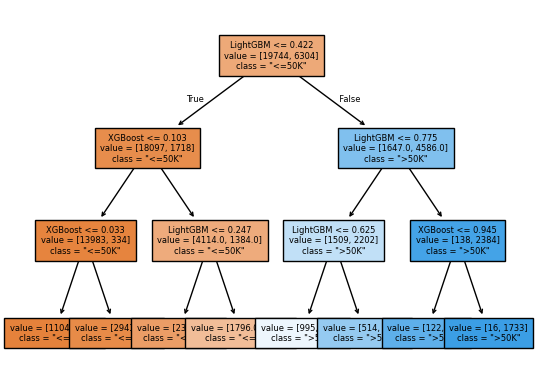

In [538]:
custom_plot_tree(stacking_model_tree.final_estimator_, 
                 feature_names=list(classifiers.keys()),
                 class_names=['"<=50K"', '">50K"'],
                 impurity=False,
                 fontsize=6)

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a better score.
- What is a disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - Slower, more code maintenance issues.

There are equivalent regression models for all of these:

- `RandomForestClassifier` $\rightarrow$ [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- `LGBMClassifier` $\rightarrow$ [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
- `XGBClassifier` $\rightarrow$ [`XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
- `CatBoostClassifier` $\rightarrow$ `CatBoostRegressor`
- `VotingClassifier` $\rightarrow$ [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)
- `StackingClassifier` $\rightarrow$ [`StackingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html)

Read documentation of each of these.

<br><br><br><br>

## Summary 

- You have a number of models in your toolbox now.  
- Ensembles are usually pretty effective.
  - Tree-based models are particularly popular and effective on a wide range of problems. 
  - But they trade off code complexity and speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally higher accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- All the above models have equivalent regression models.   

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.

- If you like to read original papers [here](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) is the original paper on Random Forests by Leo Breiman. 
- [XGBoost, LightGBM or CatBoost — which boosting algorithm should I use?](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)